# Analyzing the Phosphoinositide 3-Kinase (PI3K) Research Network
  
Phosphoinositide 3-Kinase (PI3K) is an enzyme involved with cell growth and motility, and is involved in cancer. In this notebook we will be applying Bu et. al.'s metrics both relative to the research network surrounding PI-3K as well as the detected sub-communities within the research network. We hope to identify publications that play a central role in the growth of the field.

# Data

## Starting Data

- PI3K Network: `/shared/pubmed/pi3k_pubmed_restricted_el.csv`
- PI3K Node-ID to DOI Mappings: `/shared/pubmed/pmid_doi.csv`
- PI3K Degree Distribution: `/shared/pubmed/pi3k_pubmed_restricted_nl_degree_counts.csv`

## Processed Data

- PI3K tsv Edgelist: `/shared/pubmed/pi3k_pubmed_restricted_el.tsv`
- PI3K IKC-30 Clustering: `/shared/pubmed/data/pi3k_pubmed_ikc30.csv`
- PI3K IKC-30 Reformatted Clustering: `/shared/pubmed/data/pi3k_pubmed_ikc30_reformatted.tsv`
- PI3K IKC-30 Cluster Statistics: `/shared/pubmed/data/pi3k_pubmed_ikc30_stats.csv`

**Collected During Notebook Runtime**

- PI3K IKC-30 Densest Cluster: `/shared/pubmed/data/pi3k_k49_cluster1.tsv`
- PI3K IKC-30 Densest Cluster BDID Metrics: `/shared/pubmed/data/networkit_bdid-pi3k-k49-cluster.csv`
- PI3K IKC-30 Network BDID Metrics: `/shared/pubmed/data/networkit_bdid-pi3k-network.csv`

# Pre-Processing Steps

I did several things before this analysis.

## Before Experiment I

1. First I changed the edgelist from csv to tsv format. I used the script found in this repository at `formatting_scripts/format_pi3k.py`
2. I removed the header by running `tail -n +2 pi3k_pubmed_restricted_el.tsv > pi3k_pubmed_restricted_el2.tsv`
3. I deleted `pi3k_pubmed_restricted_el.tsv` and renamed `pi3k_pubmed_restricted_el2.tsv` to `pi3k_pubmed_restricted_el.tsv`
4. Then, I clustered the tsv edgelist using IKC-30. I used the script `clustering_scripts/run_ikc.py`
5. I reformatted the clustering to be a `node_id` `cluster_id` tsv by running `formatting_scripts/format_pi3k.py`
6. Then I collected cluster statistics on the IKC-30 Clustering using [this reporting tool](https://github.com/illinois-or-research-analytics/cm_pipeline/blob/main/scripts/stats.py).

# Experiment I

## Finding the Densest K-Core Cluster

First we collect an IKC-30 clustering. Then, we need to find the most dense clustering. Let's search for the cluster with the highest k value.

In [1]:
import pandas as pd


pi3k_k_vals = pd.read_csv('/shared/pubmed/data/pi3k_pubmed_ikc30.csv')
pi3k_k_vals.head()

,18337270,1,49,1.1
0,31255140,1,49,1.0
1,22968725,1,49,1.0
2,18335787,1,49,1.0
3,18336071,1,49,1.0
4,22687254,1,49,1.0


In [2]:
# Get the maximum value in column 3
max_k = pi3k_k_vals.iloc[:, 2].max()
print(max_k)

49


It looks like we are looking at cluster 1 with a k value of 49 as our densest k-core cluster. Let's get stats on it.

In [3]:
pi3k_cluster_stats = pd.read_csv('/shared/pubmed/data/pi3k_pubmed_ikc30_stats.csv')
pi3k_cluster_stats.head()

,cluster,n,m,modularity,connectivity,connectivity_normalized_log10(n),connectivity_normalized_log2(n),connectivity_normalized_sqrt(n)/5,conductance
0,1,506,21478,0.000161,49.0,18.120293,5.454752,10.891578,0.681165
1,2,1397,61110,0.000456,48.0,15.261368,4.594130,6.421153,0.697872
2,3,2535,107177,0.000798,46.0,13.513601,4.067999,4.568134,0.688377
3,4,46132,1951190,0.011991,45.0,9.648366,2.904448,1.047566,0.715829
4,5,896,32370,0.000243,41.0,13.887440,4.180536,6.848569,0.502731


For Experiment I, we are analyzing:
  
**Cluster 1**
- 506 nodes
- 21478 edges

## Extracting an Edge List from the Cluster

Now that we have the cluster nodes, let's get an induced subgraph.

In [4]:
pi3k_ikc30 = pd.read_csv('/shared/pubmed/data/pi3k_pubmed_ikc30_reformatted.tsv', sep='\t', header=None)

pi3k_ikc30.head()

,0,1
0,18337270,1
1,31255140,1
2,22968725,1
3,18335787,1
4,18336071,1


In [7]:
first_cluster = pi3k_ikc30[pi3k_ikc30.iloc[:, 1] == 1]
first_cluster_nodes = first_cluster.iloc[:, 0].tolist()

print(first_cluster_nodes[:5])

[18337270, 31255140, 22968725, 18335787, 18336071]


In [8]:
pi3k = pd.read_csv('/shared/pubmed/pi3k_pubmed_restricted_el.tsv', sep='\t', header=None)
pi3k.head()

,0,1
0,22956746,53890765
1,22956746,55108116
2,22956746,57892820
3,22956750,31510512
4,22956750,40993204


In [10]:
# Filter rows where both columns contain values from the list
induced_subgraph = pi3k[pi3k.iloc[:, 0].isin(first_cluster_nodes) & pi3k.iloc[:, 1].isin(first_cluster_nodes)]
induced_subgraph.head()

,0,1
74230,22968725,18335787
74231,22968725,18336071
74232,22968725,18337270
74234,22968725,22687254
74235,22968725,22688518


In [11]:
print(induced_subgraph.shape[0])

21478


In [12]:
induced_subgraph.to_csv('/shared/pubmed/data/pi3k_k49_cluster1.tsv', sep='\t', header=False, index=False)

We now have an edgelist tsv for the densest cluster. Now we need BDID values.

## Getting BDID Values for PI3K and its Densest Cluster

I ran the pipeline script `pipeline/traditional_bdid_networkit.py` on both the induced subgraph and the full network. These are the commands:

- `nohup python3 pipeline/traditional_bdid_networkit.py /shared/pubmed/pi3k_pubmed_restricted_el.tsv > nohup_network.out 2> nohup_network.err &`
- `nohup python3 pipeline/traditional_bdid_networkit.py /shared/pubmed/data/pi3k_k49_cluster1.tsv > nohup_cluster.out 2> nohup_cluster.err &`
- `mv networkit_bdid-2023-11-13-02-38-11.csv /shared/pubmed/data/networkit_bdid-pi3k-k49-cluster.csv`

### Defining The Metrics

- `fp_int_id`: Node PMID
- `cp_level`: Citation count of the node

**Breadth/Depth Metrics**
- `cp_r_citing_zero`: Number of nodes citing this node that don't cite other nodes citing this node
- `cp_r_citing_nonzero`: Number of nodes citing this node that cite other nodes citing this node
- `tr_citing`: Total references between papers citing this node

**Independence/Dependence Metrics**
- `cp_r_cited_zero`: Number of nodes citing this node that don't cite nodes cited by this node
- `cp_r_cited_nonzero`: Number of nodes citing this node that cite nodes cited by this node
- `tr_cited`: Total references from papers citing this node to papers cited by this node

In [49]:
# These metrics are relative to the densest cluster
pi3k_k49_bdid = pd.read_csv('/shared/pubmed/data/networkit_bdid-pi3k-k49-cluster.csv')
pi3k_k49_bdid = pi3k_k49_bdid.dropna()
pi3k_k49_bdid.head()

,fp_int_id,cp_level,cp_r_citing_zero,cp_r_citing_nonzero,tr_citing,cp_r_cited_zero,cp_r_cited_nonzero,tr_cited
0,22968725,46,12,34,178,0,46,614
1,18335787,347,6,341,8629,1,346,2878
2,18336071,243,8,235,4090,0,243,1443
3,18337270,87,16,71,398,1,86,480
4,22687254,396,5,391,12136,6,390,1213


In [50]:
# These metrics are relative to the entire network
pi3k_full_network_bdid = pd.read_csv('/shared/pubmed/data/networkit_bdid-pi3k-network.csv')
pi3k_full_network_bdid = pi3k_full_network_bdid.dropna()
pi3k_full_network_bdid.head()

,fp_int_id,cp_level,cp_r_citing_zero,cp_r_citing_nonzero,tr_citing,cp_r_cited_zero,cp_r_cited_nonzero,tr_cited
0,22956746,0,0,0,0,0,0,0
1,53890765,493,294,199,331,253,240,443
2,55108116,493,82,411,1709,232,261,373
3,57892820,2529,271,2258,13171,2277,252,272
4,22956750,2,2,0,0,2,0,0


## Comparing Breadth/Depth Metrics

In these comparison tests, we will try two approaches to comparison. On both approaches we will be taking the distribution of scores from the cluster and comparing it to:
1. BDID of the same nodes with respect to the network.
2. BDID of randomly sampled nodes with similar network degree, but not part of the cluster. Compare distributions of BDID scores with respect to the network. I wont be doing anything with respect to the cluster.

### Approach 1.

We take the same nodes that appear in the cluster, but compare them to their metrics with respect to the network.

In [51]:
cluster_citing_zero = pi3k_k49_bdid['cp_r_citing_zero'].tolist()
cluster_citing_nonzero = pi3k_k49_bdid['cp_r_citing_nonzero'].tolist()
cluster_citing_tr = pi3k_k49_bdid['tr_citing'].tolist()
cluster_cp = pi3k_k49_bdid['cp_level'].tolist()

print(min(cluster_citing_nonzero), max(cluster_citing_nonzero))
print(min(cluster_citing_zero), max(cluster_citing_zero))
print(min(cluster_citing_tr), max(cluster_citing_tr))
print(min(cluster_cp), max(cluster_cp))

0 419
0 27
0 15528
0 425


In [52]:
app1_network = pi3k_full_network_bdid[pi3k_full_network_bdid['fp_int_id'].isin(pi3k_k49_bdid['fp_int_id'])]
app1_citing_zero = app1_network['cp_r_citing_zero'].tolist()
app1_citing_nonzero = app1_network['cp_r_citing_nonzero'].tolist()
app1_citing_tr = app1_network['tr_citing'].tolist()
app1_cp = app1_network['cp_level'].tolist()

print(min(app1_citing_nonzero), max(app1_citing_nonzero))
print(min(app1_citing_zero), max(app1_citing_zero))
print(min(app1_citing_tr), max(app1_citing_tr))
print(min(app1_cp), max(app1_cp))

0 2175
0 236
0 52933
0 2226


In [53]:
app1_network.head()

,fp_int_id,cp_level,cp_r_citing_zero,cp_r_citing_nonzero,tr_citing,cp_r_cited_zero,cp_r_cited_nonzero,tr_cited
40229,18337270,333,68,265,1351,38,295,1169
40479,31255140,186,53,133,469,9,177,1647
40823,22968725,162,38,124,661,10,152,1393
40825,18335787,1477,50,1427,24989,105,1372,7832
40826,18336071,898,58,840,9531,119,779,3338


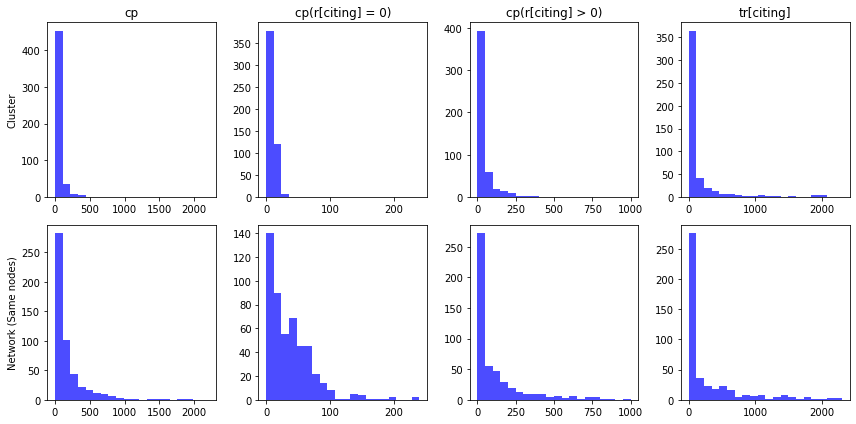

In [54]:
import matplotlib.pyplot as plt
import numpy as np


# Create a 2x4 grid of histograms
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Plot histograms in each subplot
axes[0].hist(cluster_cp, bins=20, range=(0, 2200), color='blue', alpha=0.7)
axes[1].hist(cluster_citing_zero, bins=20, range=(0, 240), color='blue', alpha=0.7)
axes[2].hist(cluster_citing_nonzero, bins=20,range=(0, 1000), color='blue', alpha=0.7)
axes[3].hist(cluster_citing_tr, bins=20, range=(0, 2300), color='blue', alpha=0.7)

axes[4].hist(app1_cp, bins=20, range=(0, 2200), color='blue', alpha=0.7)
axes[5].hist(app1_citing_zero, bins=20, range=(0, 240), color='blue', alpha=0.7)
axes[6].hist(app1_citing_nonzero, bins=20, range=(0, 1000), color='blue', alpha=0.7)
axes[7].hist(app1_citing_tr, bins=20, range=(0, 2300), color='blue', alpha=0.7)

col_titles = ['cp', 'cp(r[citing] = 0)', 'cp(r[citing] > 0)', 'tr[citing]']

# Add labels and title
for i, ax in enumerate(axes):
    if i <= 3:
        ax.set_title(col_titles[i])
    if (i == 0):
        ax.set_ylabel('Cluster')
    elif (i == 4):
        ax.set_ylabel('Network (Same nodes)')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


It looks like there is a lot of difference due to differences in citations that will occur naturally when the dataset is constrained. However, we do see higher differences in `cp(r[citing] = 0)`'s difference, and more similarity in the other breadth/depth metrics.

This could potentially be explained by the fact that those outside the subfield may use a single bit of information from the paper, without needing more info from related papers. Therefore, they will not cite other papers citing the publication.

We should favor an approach that doesn't have this confounding variable that is the citation count. Hence, we should use relative indicators that normalize by the cp. 

**I am not considering publications with cp=0 since the normalized values will be 0/0 and therefore undefined.**

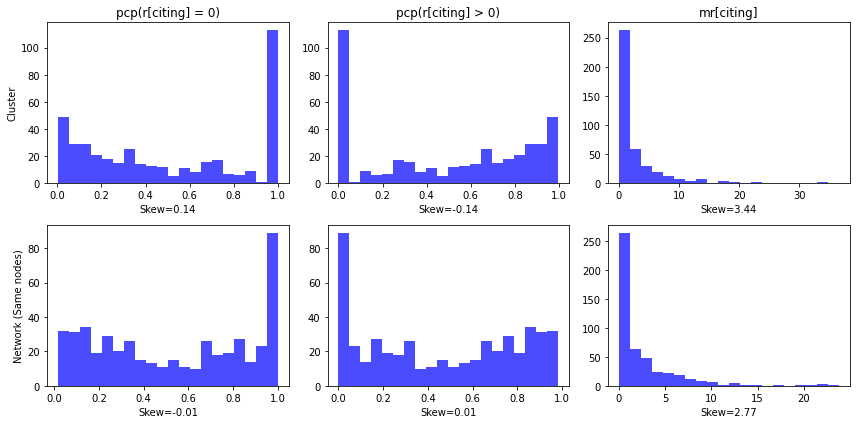

In [63]:
from scipy.stats import skew

cluster_citing_zero_norm = (pi3k_k49_bdid['cp_r_citing_zero']/pi3k_k49_bdid['cp_level']).tolist()
cluster_citing_nonzero_norm = (pi3k_k49_bdid['cp_r_citing_nonzero']/pi3k_k49_bdid['cp_level']).tolist()
cluster_citing_mr = (pi3k_k49_bdid['tr_citing']/pi3k_k49_bdid['cp_level']).tolist()

app1_citing_zero_norm = (app1_network['cp_r_citing_zero']/app1_network['cp_level']).tolist()
app1_citing_nonzero_norm = (app1_network['cp_r_citing_nonzero']/app1_network['cp_level']).tolist()
app1_citing_mr = (app1_network['tr_citing']/app1_network['cp_level']).tolist()

datasets = [
    cluster_citing_zero_norm,
    cluster_citing_nonzero_norm,
    cluster_citing_mr,
    app1_citing_zero_norm,
    app1_citing_nonzero_norm,
    app1_citing_mr
]

replace_nan = lambda l : [x for x in l if not np.isnan(x)]
datasets = [replace_nan(dataset) for dataset in datasets]

# Create a 2x4 grid of histograms
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Plot histograms in each subplot
for i, _ in enumerate(axes):
    axes[i].hist(datasets[i], bins=20, color='blue', alpha=0.7)

col_titles = ['pcp(r[citing] = 0)', 'pcp(r[citing] > 0)', 'mr[citing]']

# Add labels and title
for i, ax in enumerate(axes):
    if i <= 2:
        ax.set_title(col_titles[i])
    if (i == 0):
        ax.set_ylabel('Cluster')
    elif (i == 3):
        ax.set_ylabel('Network (Same nodes)')
        
    ax.set_xlabel(f'Skew={round(skew(datasets[i]), 2)}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Within the cluster, nodes have a much higher skew for breadth/depth metrics. We observe a more right skew in zero citing and a more left skew in nonzero citing. This suggests that lower breadth and higher depth is favored within a dense cluster vs with respect to a network.

However, we see that in the left plots we have a spike at 1, and in the right plots we have a spike of 0. This means that for those publications, no paper citing them cited each other. *Hypothesis: These exist at the edge of the cluster*, especially since there 

### Approach 2.

We will sample other nodes from outside the cluster that have a network degree similar to the nodes in the cluster. First, lets look at the degree distribution within the cluster.

In [39]:
pi3k_degrees = pd.read_csv('/shared/pubmed/pi3k_pubmed_restricted_nl_degree_counts.csv')
pi3k_degrees.head()

,node_id,in_deg,out_deg,total_degree
0,13,8,0,8
1,14,3,0,3
2,16,353,0,353
3,19,7,0,7
4,24,67,0,67
